# Time Series Classification

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib
from tslearn.utils import to_time_series_dataset, save_time_series_txt, load_time_series_txt
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import pickle

In [2]:
data_path = '/home/mattiapggioli/lyrics2ts/data/classification/20ng/sbert/'
truncate=100
max_iter = 2000
paa_window_size = None
undersampling = None

In [3]:
# Parameters
data_path = "/home/mattiapggioli/lyrics2ts/data/classification/20ng/sentiment/"


In [4]:
ts = load_time_series_txt(f'{data_path}/ts.txt')

In [5]:
ts.shape

(1775, 1210, 1)

In [6]:
with open(f'{data_path}/y_class.npy', 'rb') as f:
    y = np.load(f, allow_pickle=True)

In [7]:
with open(f'{data_path}/X.npy', 'rb') as f:
    X = np.load(f, allow_pickle=True)

In [8]:
X.shape

(1775, 6)

In [9]:
set(y)

{'comp', 'misc', 'rec', 'religion', 'sci', 'talk'}

In [10]:
ts_train, ts_test, y_train, y_test = train_test_split(ts, y, test_size=0.20, random_state=42)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [12]:
random.choice(ts_train)

array([[0.    ],
       [0.0772],
       [0.1901],
       ...,
       [   nan],
       [   nan],
       [   nan]])

<AxesSubplot:ylabel='Count'>

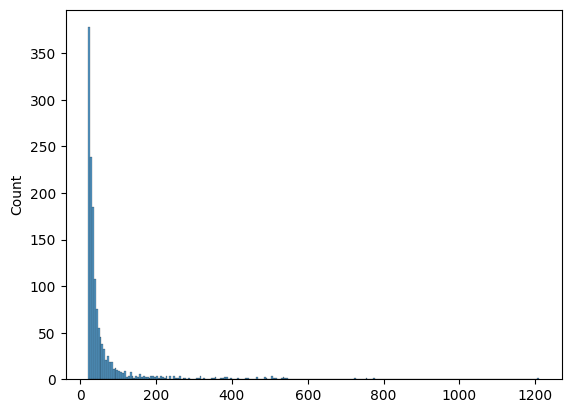

In [13]:
sns.histplot([t[~np.any(np.isnan(t), axis=1)].shape[0] for t in ts_train])

In [14]:
ts_train = ts_train[:, :truncate, :]
ts_test = ts_test[:, :truncate, :]

In [15]:
mean_arr = np.nanmean(ts_train, axis=1, keepdims=True)
nan_indices = np.isnan(ts_train)
ts_train[nan_indices] = np.take(mean_arr, np.nonzero(nan_indices)[0])

mean_arr = np.nanmean(ts_test, axis=1, keepdims=True)
nan_indices = np.isnan(ts_test)
ts_test[nan_indices] = np.take(mean_arr, np.nonzero(nan_indices)[0])

In [16]:
np.count_nonzero(np.isnan(X_train))

22

In [17]:
X_train[np.isnan(X_train)] = 0
X_test[np.isnan(X_test)] = 0

In [18]:
save_time_series_txt(f'{data_path}/ts_train.txt', ts_train)
save_time_series_txt(f'{data_path}/ts_test.txt', ts_test)

In [19]:
with open(f'{data_path}/X_train.npy', 'wb') as f:
    np.save(f, X_train, allow_pickle=True)

with open(f'{data_path}/X_test.npy', 'wb') as f:
    np.save(f, X_test, allow_pickle=True)

In [20]:
with open(f'{data_path}/y_train.npy', 'wb') as f:
    np.save(f, y_train, allow_pickle=True)

with open(f'{data_path}/y_test.npy', 'wb') as f:
    np.save(f, y_test, allow_pickle=True)

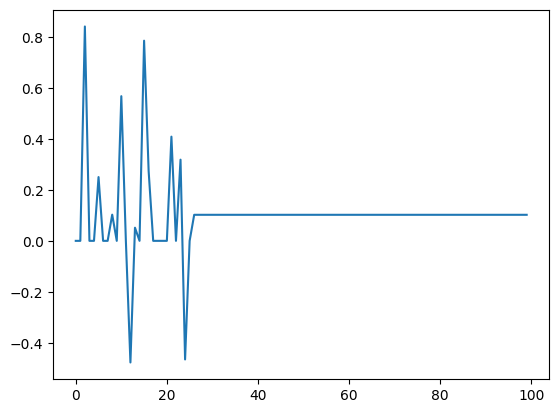

In [21]:
plt.plot(random.choice(ts_train))

In [22]:
# Parameters that require knowing if it's binary or multiclass (LightGBM, metrics)
if len(set(y)) == 2:
    avg_par = 'binary'
    obj_par = 'binary'
elif len(set(y)) > 2:
    avg_par = 'macro'
    obj_par = 'multiclass'

## Classification

In [23]:
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgbm
from sklearn.ensemble import RandomForestClassifier

In [24]:
metrics_data = {}

### Baseline: global features (No Time Series)

In [25]:
metrics_data['Global'] = {}

**Decision Tree**

In [26]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [27]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        comp       0.37      0.34      0.35        50
        misc       0.25      0.12      0.17         8
         rec       0.16      0.21      0.19        47
    religion       0.40      0.39      0.39        83
         sci       0.27      0.29      0.28        77
        talk       0.50      0.46      0.48        90

    accuracy                           0.35       355
   macro avg       0.33      0.30      0.31       355
weighted avg       0.36      0.35      0.35       355



In [28]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

metrics_data['Global']['DecisionTree'] = {'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1': f1}

**Random Forest**

In [29]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [30]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        comp       0.29      0.28      0.29        50
        misc       0.33      0.25      0.29         8
         rec       0.23      0.13      0.16        47
    religion       0.38      0.45      0.41        83
         sci       0.24      0.19      0.21        77
        talk       0.46      0.59      0.52        90

    accuracy                           0.36       355
   macro avg       0.32      0.31      0.31       355
weighted avg       0.34      0.36      0.34       355



In [31]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

metrics_data['Global']['RandomForest'] = {'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1': f1}

**LightGBM**

In [32]:
clf = lgbm.LGBMClassifier(objective=obj_par) 
clf.fit(X_train, y_train)

LGBMClassifier(objective='multiclass')

In [33]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        comp       0.35      0.34      0.34        50
        misc       0.25      0.12      0.17         8
         rec       0.28      0.17      0.21        47
    religion       0.37      0.39      0.38        83
         sci       0.32      0.29      0.30        77
        talk       0.46      0.60      0.52        90

    accuracy                           0.38       355
   macro avg       0.34      0.32      0.32       355
weighted avg       0.36      0.38      0.37       355



In [34]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

metrics_data['Global']['LightGBM'] = {'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1': f1}

### Time Series Classification

#### Learning Shapelets

In [35]:
from tslearn.shapelets import LearningShapelets, grabocka_params_to_shapelet_size_dict

2023-03-08 12:28:03.006716: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 12:28:03.166029: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-08 12:28:03.166052: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2023-03-08 12:28:03.784974: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-08 12:28:03.785045: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-08 12:28:03.785053: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [36]:
n_ts, ts_sz, _ = ts_train.shape
n_classes = len(set(y_train))

In [37]:
# Set the number of shapelets per size as done in the original paper
g_shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                         ts_sz=ts_sz,
                                                         n_classes=n_classes,
                                                         l=0.1,
                                                         r=1)

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', g_shapelet_sizes)

n_ts 1420
ts_sz 100
n_classes 6
shapelet_sizes {10: 5}


In [38]:
shapelet_sizes = {}
for key in g_shapelet_sizes:
    shapelet_sizes[key] = g_shapelet_sizes[key]
    shapelet_sizes[key*2] = g_shapelet_sizes[key]
    shapelet_sizes[key//2] = g_shapelet_sizes[key]
shapelet_sizes

{10: 5, 20: 5, 5: 5}

In [39]:
model = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                          optimizer="adam", 
                          weight_regularizer=.01, 
                          max_iter=max_iter, verbose=0, random_state=42)

/home/mattiapggioli/lyrics2ts/.venv/lib/python3.9/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


In [40]:
%%time
model.fit(ts_train, y_train)

2023-03-08 12:28:04.833793: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-08 12:28:04.833817: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-08 12:28:04.833839: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mattiapggioli-ThinkPad-E595): /proc/driver/nvidia/version does not exist
2023-03-08 12:28:04.834083: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


CPU times: user 9min 57s, sys: 32.3 s, total: 10min 29s
Wall time: 2min 24s


LearningShapelets(max_iter=2000, n_shapelets_per_size={5: 5, 10: 5, 20: 5},
                  optimizer='adam', random_state=42, weight_regularizer=0.01)

In [41]:
model.to_pickle(f'{data_path}/shapelets.pkl')

#### Shapelet-Based Classification

In [42]:
metrics_data['Shapelets'] = {}

In [43]:
X_train = model.transform(ts_train)
X_test = model.transform(ts_test)

In [44]:
pd.DataFrame(X_test)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,2.716074,0.013605,1.341437,4.306818,0.073890,1.691845,0.338684,2.939410,3.651063,1.593321,3.259902,3.334395,3.461263,0.700475,3.783192
1,3.034532,0.042133,2.041426,4.118248,0.041047,1.958957,0.330426,2.860681,3.372937,2.012018,3.406604,3.507000,3.622049,0.730464,3.905253
2,2.444720,0.087158,2.683060,2.928268,0.025227,2.314481,0.136286,1.932372,2.465432,2.230859,4.278711,4.385475,4.533967,1.097894,4.841006
3,2.952698,0.012931,2.041159,4.215336,0.008626,1.847431,0.293963,2.683455,3.367093,2.001285,3.431801,3.513959,3.638619,0.766692,3.933697
4,2.298749,0.037807,1.878178,4.866575,0.040437,1.575195,0.369454,3.043684,4.040675,1.558295,3.079355,3.146288,3.265894,0.593570,3.554067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,2.793933,0.039273,2.170800,4.816931,0.046044,1.876254,0.350805,2.799296,3.696451,1.794792,3.608492,3.685897,3.830227,0.785629,4.124905
351,2.640495,0.050788,2.297983,3.753809,0.021652,1.734200,0.239592,2.371541,2.845615,1.888453,3.894150,3.975357,4.134034,0.906378,4.431640
352,2.665391,0.004702,1.684811,3.379068,0.036199,1.697337,0.240689,2.074420,2.481601,1.758750,3.457773,3.510777,3.650588,0.713765,3.941224
353,1.736136,0.014164,1.761193,2.625911,0.012748,1.629735,0.107761,2.122910,2.810987,1.873741,3.349716,3.443133,3.577986,0.700481,3.835438


**Decision Tree**

In [45]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [46]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        comp       0.27      0.24      0.25        50
        misc       0.14      0.12      0.13         8
         rec       0.12      0.11      0.11        47
    religion       0.22      0.20      0.21        83
         sci       0.25      0.29      0.27        77
        talk       0.40      0.43      0.42        90

    accuracy                           0.27       355
   macro avg       0.23      0.23      0.23       355
weighted avg       0.27      0.27      0.27       355



In [47]:
pickle.dump(clf, open(f'{data_path}/decision_tree.pkl', 'wb'))

In [48]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

metrics_data['Shapelets']['DecisionTree'] = {'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1': f1}

**Random Forest**

In [49]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [50]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        comp       0.36      0.32      0.34        50
        misc       1.00      0.25      0.40         8
         rec       0.18      0.09      0.12        47
    religion       0.34      0.53      0.42        83
         sci       0.32      0.18      0.23        77
        talk       0.50      0.62      0.55        90

    accuracy                           0.38       355
   macro avg       0.45      0.33      0.34       355
weighted avg       0.37      0.38      0.36       355



In [51]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

metrics_data['Shapelets']['RandomForest'] = {'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1': f1}

**LightGBM**

In [52]:
clf = lgbm.LGBMClassifier(objective=obj_par) 
clf.fit(X_train, y_train)

LGBMClassifier(objective='multiclass')

In [53]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        comp       0.40      0.32      0.36        50
        misc       1.00      0.12      0.22         8
         rec       0.43      0.32      0.37        47
    religion       0.36      0.51      0.42        83
         sci       0.33      0.23      0.27        77
        talk       0.47      0.56      0.51        90

    accuracy                           0.40       355
   macro avg       0.50      0.34      0.36       355
weighted avg       0.41      0.40      0.39       355



In [54]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

metrics_data['Shapelets']['LightGBM'] = {'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1': f1}

#### KNN

In [55]:
X_train = ts_train.reshape((ts_train.shape[0], ts_train.shape[1]))
X_test = ts_test.reshape((ts_test.shape[0], ts_test.shape[1]))

In [56]:
X_train.shape

(1420, 100)

In [57]:
metrics_data['KNN'] = {}

**Euclidean Distance**

In [58]:
from sklearn.neighbors import KNeighborsClassifier

In [59]:
clf = KNeighborsClassifier(n_neighbors=5, weights='uniform')
clf.fit(X_train, y_train)

KNeighborsClassifier()

In [60]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        comp       0.18      0.62      0.28        50
        misc       0.11      0.25      0.15         8
         rec       0.09      0.09      0.09        47
    religion       0.31      0.11      0.16        83
         sci       0.20      0.16      0.18        77
        talk       0.69      0.27      0.38        90

    accuracy                           0.23       355
   macro avg       0.26      0.25      0.21       355
weighted avg       0.33      0.23      0.23       355



In [61]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

metrics_data['KNN']['Euclidean'] = {'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1': f1}

**Dynamic Time Warping**

In [62]:
from pyts.classification import KNeighborsClassifier
from pyts.approximation import PiecewiseAggregateApproximation
from imblearn.under_sampling import ClusterCentroids
from sklearn_extra.cluster import KMedoids

In [63]:
if paa_window_size:
    paa = PiecewiseAggregateApproximation(window_size=paa_window_size)
    X_train = paa.transform(X_train)
    X_test = paa.transform(X_test)
    X_train.shape

In [64]:
if undersampling:
    total_samples = len(y_train)
    unique_classes, class_counts = np.unique(y_train, return_counts=True)
    samp_strat = dict(zip(unique_classes, np.floor(class_counts * undersampling).astype(int)))
    print(samp_strat)
    cc = ClusterCentroids(estimator=KMedoids(
        random_state=42), sampling_strategy=samp_strat, random_state=42)
    X_train, y_train = cc.fit_resample(X_train, y_train)
    X_train.shape

In [65]:
clf = KNeighborsClassifier(metric='dtw_sakoechiba',  metric_params={'window_size':3})

clf.fit(X_train, y_train)

KNeighborsClassifier(metric='dtw_sakoechiba', metric_params={'window_size': 3})

In [66]:
%%time
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        comp       0.26      0.38      0.31        50
        misc       0.24      0.50      0.32         8
         rec       0.15      0.15      0.15        47
    religion       0.31      0.22      0.26        83
         sci       0.19      0.19      0.19        77
        talk       0.42      0.38      0.40        90

    accuracy                           0.27       355
   macro avg       0.26      0.30      0.27       355
weighted avg       0.28      0.27      0.27       355

CPU times: user 1min 32s, sys: 78.9 ms, total: 1min 32s
Wall time: 1min 32s


In [67]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

metrics_data['KNN']['DTW'] = {'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1': f1}

## Overall Results

In [68]:
metrics_data = pd.DataFrame.from_dict({(i,j): metrics_data[i][j] 
                                       for i in metrics_data.keys() 
                                       for j in metrics_data[i].keys()},
                                       orient='index')

In [69]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

In [70]:
metrics_data

Accuracy  Precision    Recall        F1
Global    DecisionTree  0.346479   0.325028  0.300763  0.308581
          RandomForest  0.357746   0.322721  0.314523  0.313091
          LightGBM      0.377465   0.336962  0.317745  0.319963
Shapelets DecisionTree  0.270423   0.234070  0.232542  0.232720
          RandomForest  0.383099   0.448703  0.331545  0.341835
          LightGBM      0.400000   0.497521  0.343249  0.357328
KNN       Euclidean     0.230986   0.263970  0.247675  0.207460
          DTW           0.273239   0.260953  0.303064  0.270746

In [71]:
metrics_data.to_csv(f'{data_path}/metrics.csv')